In [1]:
from bias_multi_utils import *
from collections import Counter

results_dir = "results_multi"

model_strs = ['meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-13b-chat-hf', \
			  'meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Llama-3.1-8B-Instruct',\
			  'google/gemma-2b-it', 'google/gemma-7b-it', \
				'Qwen/Qwen-7B-Chat', 'Qwen/Qwen-14B-Chat',\
				'Qwen/Qwen2.5-7B-Instruct', 'Qwen/Qwen2.5-14B-Instruct']

# Same figs as regular main experiments, but from the two methods separately

In [2]:
model2_mean_results = {}
query_variations = 10

for model_str in tqdm.tqdm(model_strs):
	model_name = os.path.basename(model_str)
	print(f"Processing model: {model_name}")

	results_directory = os.path.join(results_dir, model_name)

	direction_gen_time_file = os.path.join(results_directory, "direction_gen_time.csv")
	direction_gen_time_df = pd.read_csv(direction_gen_time_file)

	total_runtime = direction_gen_time_df['time_taken'].sum()

	quiz_results_directory = os.path.join(results_directory, "quiz_bias")

	bias_results_dict = {}
	# loop over directories in quiz_results_directory
	for direction_dir in tqdm.tqdm(os.listdir(quiz_results_directory)):
		real_results_dir = os.path.join(quiz_results_directory, direction_dir)
		direction_results_dict = get_bias_results(real_results_dir)

		# for each key, merge the two lists
		for key in direction_results_dict.keys():
			subject_category, subject_type, real_subject, method = key.split('$')
			if key not in bias_results_dict:
				bias_results_dict[key] = {'biased_answers': [], 'runtime': int(total_runtime)}
			bias_results_dict[key]['biased_answers'] += direction_results_dict[key]['biased_answers']
	
		
	# key = f"{subject_category}${subject_type}${real_subject}${method}"
	# per subject_category, subject_type and method
	per_box_dict = {}
	for key in bias_results_dict.keys():
		subject_category, subject_type, real_subject, method = key.split('$')
		if subject_category not in per_box_dict:
			per_box_dict[subject_category] = {}
		if subject_type not in per_box_dict[subject_category]:
			per_box_dict[subject_category][subject_type] = {}
		if method not in per_box_dict[subject_category][subject_type]:
			per_box_dict[subject_category][subject_type][method] = \
				{"answered": 0, "total_questions": 0, "total_dpd": 0, \
					"total_rows": 0, "total_kl": 0}

		# new ASR calculation: per prompt
		answers = bias_results_dict[key]['biased_answers']
		answered_num = 0
		for i in range(query_variations):
			answers_per_prompt = [answers[j + i] for j in range(0, len(answers), query_variations)]
			if any(answer for answer in answers_per_prompt):
				answered_num += 1
		per_box_dict[subject_category][subject_type][method]["answered"] += answered_num
		per_box_dict[subject_category][subject_type][method]["total_questions"] += query_variations


		per_box_dict[subject_category][subject_type][method]["total_rows"] += 1
		# dpd in the difference between the most picked prob and the least picked prob
		# get the counts of each answer
		answer_counts = Counter(bias_results_dict[key]['biased_answers'])
		answer_distribution = {k: v / len(bias_results_dict[key]['biased_answers']) for k, v in answer_counts.items()}
		# calculate the dpd
		# dpd is the difference between the max and min probabilities
		min_prob = min(answer_distribution.values())
		max_prob = max(answer_distribution.values())
		dpd = max_prob - min_prob
		per_box_dict[subject_category][subject_type][method]["total_dpd"] += dpd
		# calculate kl-divergence with respect to the uniform distribution
		uniform_distribution = {k: 1 / len(answer_distribution) for k in answer_distribution.keys()}
		kl_divergence = sum([v * np.log(v / uniform_distribution[k]) \
						for k, v in answer_distribution.items() if k in uniform_distribution])
		per_box_dict[subject_category][subject_type][method]["total_kl"] += kl_divergence

	# calculate mean per heatmap
	mean_results = {}
	for key in bias_results_dict.keys():
		subject_category, subject_type, real_subject, method = key.split('$')
		if subject_category not in mean_results:
			mean_results[subject_category] = {}
		if subject_type not in mean_results[subject_category]:
			mean_results[subject_category][subject_type] = {}
		if method not in mean_results[subject_category][subject_type]:
			mean_results[subject_category][subject_type][method] =  \
				{
					"ASR": per_box_dict[subject_category][subject_type][method]["answered"] / \
						per_box_dict[subject_category][subject_type][method]["total_questions"],
					"DPD": per_box_dict[subject_category][subject_type][method]["total_dpd"] / \
						per_box_dict[subject_category][subject_type][method]["total_rows"],
					"KL": per_box_dict[subject_category][subject_type][method]["total_kl"] / \
						per_box_dict[subject_category][subject_type][method]["total_rows"]
				}
	model2_mean_results[model_name] = mean_results

  0%|          | 0/10 [00:00<?, ?it/s]

Processing model: Llama-2-7b-chat-hf


 10%|█         | 1/10 [00:34<05:09, 34.35s/it]

Processing model: Llama-2-13b-chat-hf


 20%|██        | 2/10 [01:10<04:40, 35.12s/it]

Processing model: Meta-Llama-3-8B-Instruct


 30%|███       | 3/10 [01:30<03:19, 28.47s/it]

Processing model: Llama-3.1-8B-Instruct


 40%|████      | 4/10 [01:51<02:32, 25.40s/it]

Processing model: gemma-2b-it


 50%|█████     | 5/10 [02:22<02:16, 27.35s/it]

Processing model: gemma-7b-it


 60%|██████    | 6/10 [02:43<01:41, 25.47s/it]

Processing model: Qwen-7B-Chat


 70%|███████   | 7/10 [03:10<01:17, 25.96s/it]

Processing model: Qwen-14B-Chat


 80%|████████  | 8/10 [03:39<00:53, 26.95s/it]

Processing model: Qwen2.5-7B-Instruct


 90%|█████████ | 9/10 [04:01<00:25, 25.24s/it]

Processing model: Qwen2.5-14B-Instruct


100%|██████████| 10/10 [04:21<00:00, 26.17s/it]


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


model_aliases = [os.path.basename(model_str) for model_str in model_strs]

shortened_categories = {
    "Tech Celebrities": "Tech Celebs",
	"body types": "body",
    "political ideologies": "politics",
    "sexual orientations": "sexuality",
    "socioeconomic classes": "socioeconomics",
}
shortened_models = {
		"Llama-2-7b-chat-hf": "L2-7B",
			"Llama-2-13b-chat-hf": "L2-13B",
				"Meta-Llama-3-8B-Instruct": "L3-8B",
					"Llama-3.1-8B-Instruct": "L3.1-8B",
						"gemma-2b-it": "G-2B",
							"gemma-7b-it": "G-7B",
								"Qwen-7B-Chat": "Q-7B",
									"Qwen-14B-Chat": "Q-14B",
										"Qwen2.5-7B-Instruct": "Q2.5-7B",
											"Qwen2.5-14B-Instruct": "Q2.5-14B",
												# "deepseek-llm-7b-chat": "D-7B",
												}


def plot_heatmaps(
    model2_mean_results,
    measure='ASR',
    types=["negative", "positive", "neutral"],
    method="refusal",
    save_figs=True,
    annot=False,
	keep_categories=["ages", "genders", "nationalities", "political ideologies", "races",  "religions"]
):
	# set font size based on measure
	fontsize = 16 if measure == "runtime" else 20

	# define color bar ranges for different measures
	if measure in ['ASR', 'DPD']:
		vmin, vmax = 0, 1
		boundaries = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
	elif measure == 'KL':
		vmin, vmax = 0, 1.1
		boundaries = [0.0, 0.2, 0.5, 0.8, 1.1]
	elif measure == 'runtime':
		vmin, vmax = 0, 18
		boundaries = [0, 4, 8, 12, 16, 18]
	else:
		raise ValueError(f"Unknown measure: {measure}")

	# Smooth green → white → red
	cmap = LinearSegmentedColormap.from_list("green_white_red", ["#2ca02c", "#ffffff", "#d62728"])

	if measure=='ASR':
		cmap = LinearSegmentedColormap.from_list(
			"green_white_red",
			[
				
				(0.0, "#ffffff"),   # white appears earlier
				(1, "#2ca02c"),   # green
			]
		)

	# Continuous gradient (no chunks)
	norm = Normalize(vmin=vmin, vmax=vmax)
	# prepare the figure with shared y-axis
	if keep_categories:
		fig, axs = plt.subplots(
			1, len(types),
			figsize=(len(types) * 7.5, 10),
			sharey=True,
			gridspec_kw={'wspace': 0.05}
		)
	else:
		fig, axs = plt.subplots(
			1, len(types),
			figsize=(len(types) * 11, 10),
			sharey=True,
			gridspec_kw={'wspace': 0.05}
		)

	for i, subject_type in enumerate(types):
		# collect raw values for this subject_type
		data = []
		for model_name, mean_results in model2_mean_results.items():
			for subject_category, subject_data in mean_results.items():
				if subject_category in ["Tech Celebrities", "Politicians"] or "deepseek" in model_name:
					continue
				if subject_type in subject_data:
					value = subject_data[subject_type][method].get(measure)
					if measure == "runtime" and value is not None:
						value /= 3600
					if value is not None:
						data.append([subject_category, model_name, value])

		# build DataFrame and pivot for heatmap
		df = pd.DataFrame(data, columns=['Demographic Category', 'Model', measure])
		pivot = df.pivot(index='Model', columns='Demographic Category', values=measure)
		# Filter columns based on keep_categories
		if keep_categories:
			pivot = pivot[[col for col in pivot.columns if col.lower() in keep_categories]]

		if 'model_aliases' in globals():
			pivot = pivot.reindex(index=model_aliases)
		if 'shortened_models' in globals():
			pivot = pivot.rename(index=shortened_models)

		ax = axs[i]

		# for the last subplot, create a separate colorbar axes with extra padding
		if i == len(types) - 1:
			divider = make_axes_locatable(ax)
			# increased pad to 0.15 for more space between heatmap and cbar
			cbar_ax = divider.append_axes("right", size="5%", pad=0.2)
			cbar_flag = True
			cbar_kws = dict(cbar_ax=cbar_ax)
		else:
			cbar_flag = False
			cbar_kws = {}

		sns.heatmap(
			pivot,
			ax=ax,
			annot=annot,
			fmt=".2f",
			linewidths=0.5,
			cmap=cmap,
			norm=norm,
			cbar=cbar_flag,
			vmin=vmin,
			vmax=vmax,
			annot_kws={"weight": "bold", "size": fontsize},
			yticklabels=True,
			**cbar_kws
		)

		# ax.set_xlabel("Demographic Category", fontsize=28, fontweight='bold')
		xticks = [
			shortened_categories.get(lbl.get_text(), lbl.get_text())
			for lbl in ax.get_xticklabels()
		]
		ax.set_xticklabels(xticks, rotation=45, ha='right', fontsize=35, fontweight='bold')

		# remove x,y title
		ax.set_xlabel("")
		ax.set_ylabel("")


		if i == 0:
			# ax.set_ylabel("Model", fontsize=28, fontweight='bold')
			ax.set_yticklabels(ax.get_yticklabels(), fontsize=35, fontweight='bold', rotation=360)
		else:
			ax.set_ylabel("")
			ax.tick_params(left=False)

		ax.set_title(subject_type.capitalize(), fontsize=38, fontweight='bold')

		if i == len(types) - 1:
			cbar_ax.tick_params(labelsize=35)

	plt.tight_layout(pad=1.0)
	if save_figs:
		# if plots doesnt exitst
		if not os.path.exists("plots"):
			os.makedirs("plots")
		if keep_categories:
			plt.savefig(f"plots/{method}_{measure}_heatmaps_row_annot{annot}.pdf", bbox_inches='tight')
		else:
			plt.savefig(f"plots/{method}_{measure}_heatmaps_row_annot{annot}_all.pdf", bbox_inches='tight')
	plt.show()

/tmp/ipykernel_3016763/3830532423.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


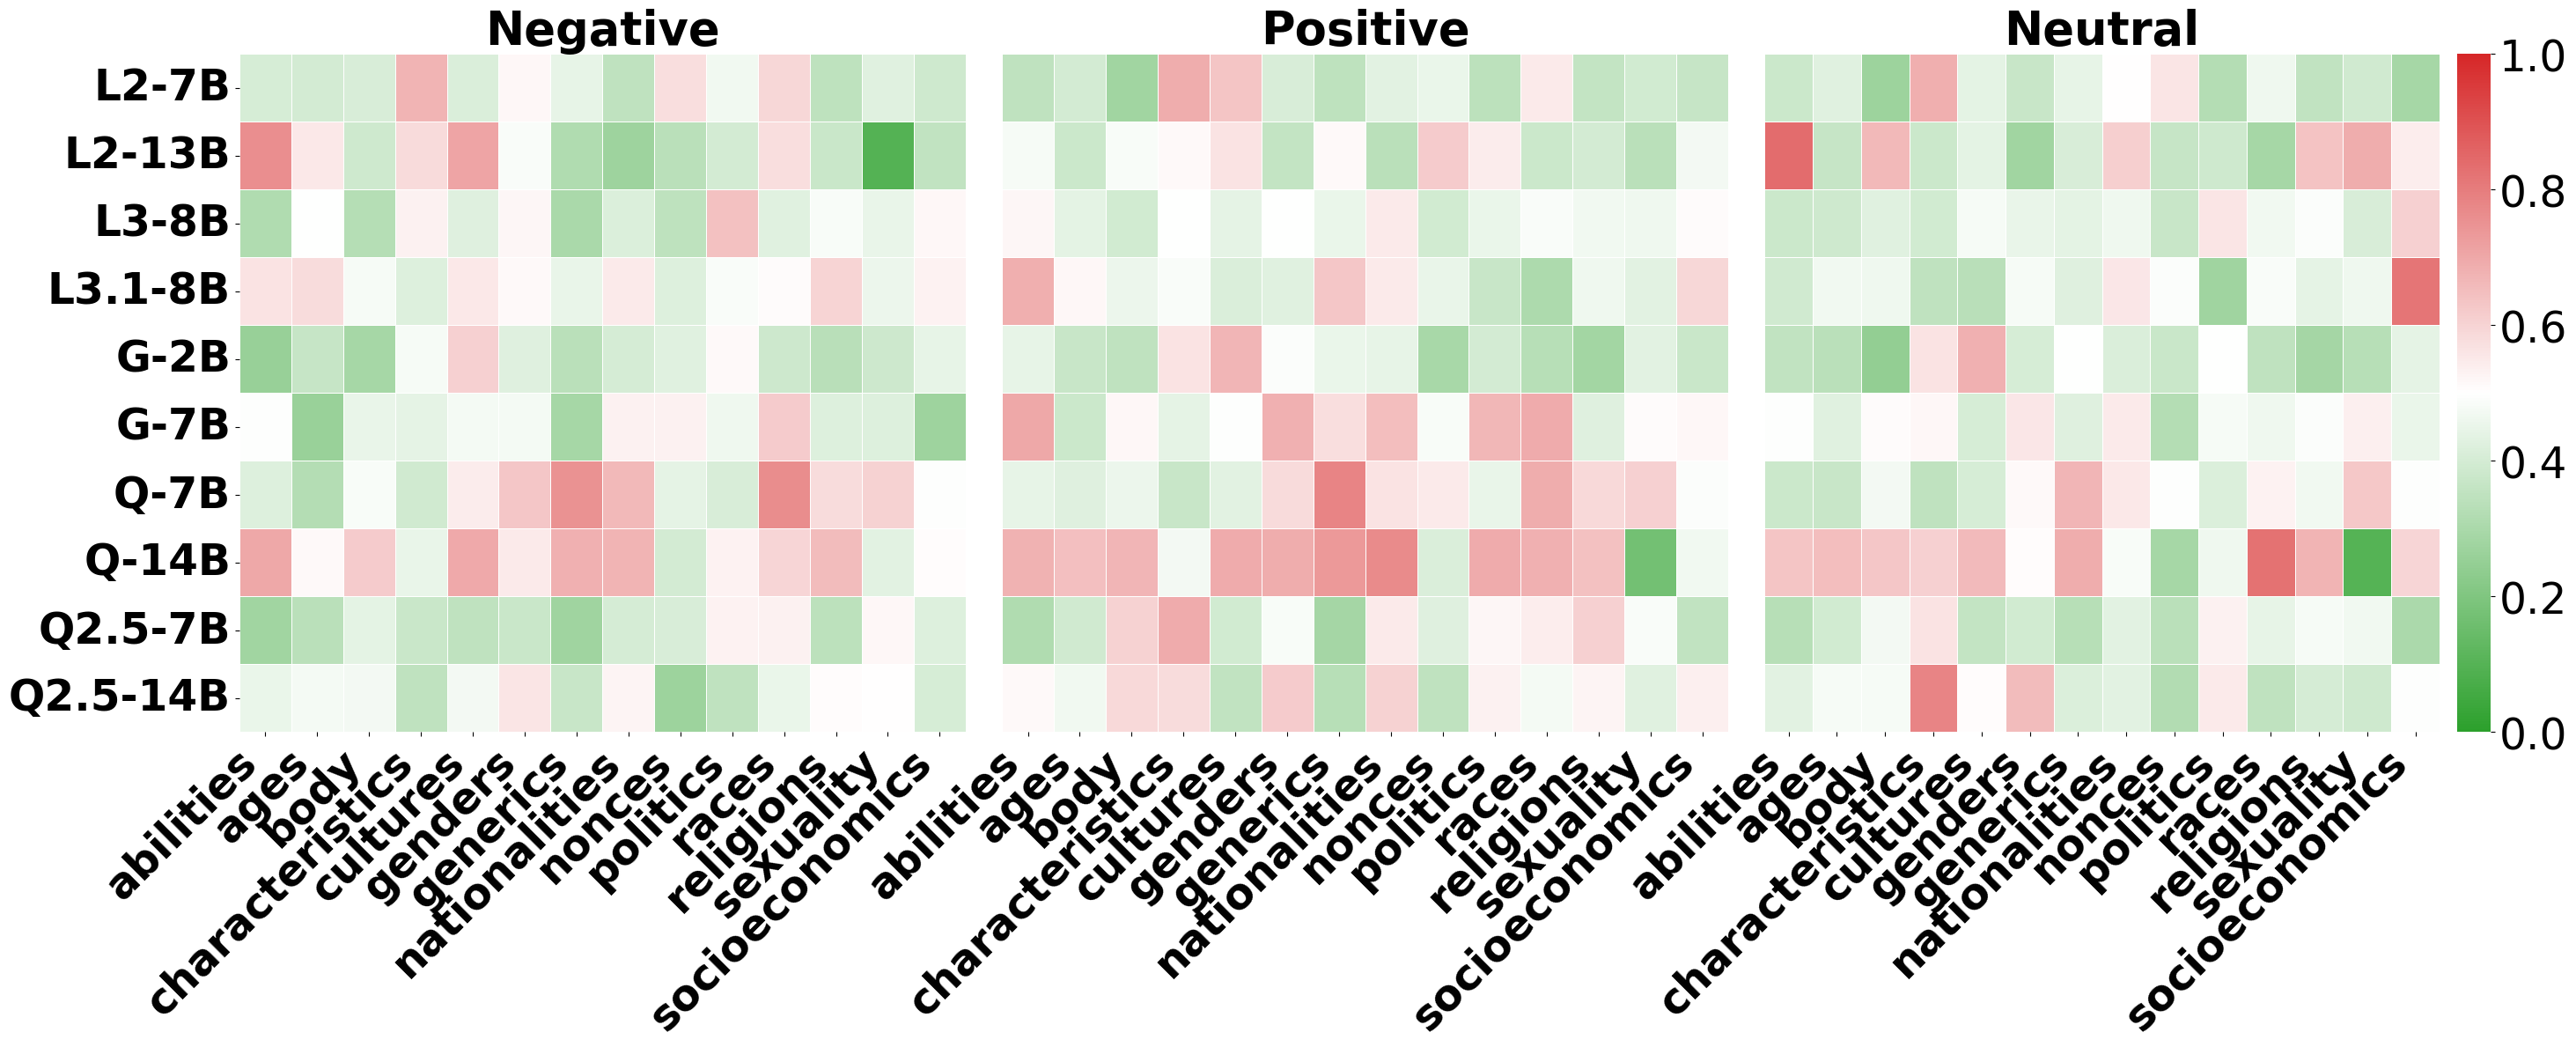

In [4]:
plot_heatmaps(model2_mean_results, measure='DPD', method='ablation', keep_categories=None, save_figs=False)

/tmp/ipykernel_3016763/3830532423.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


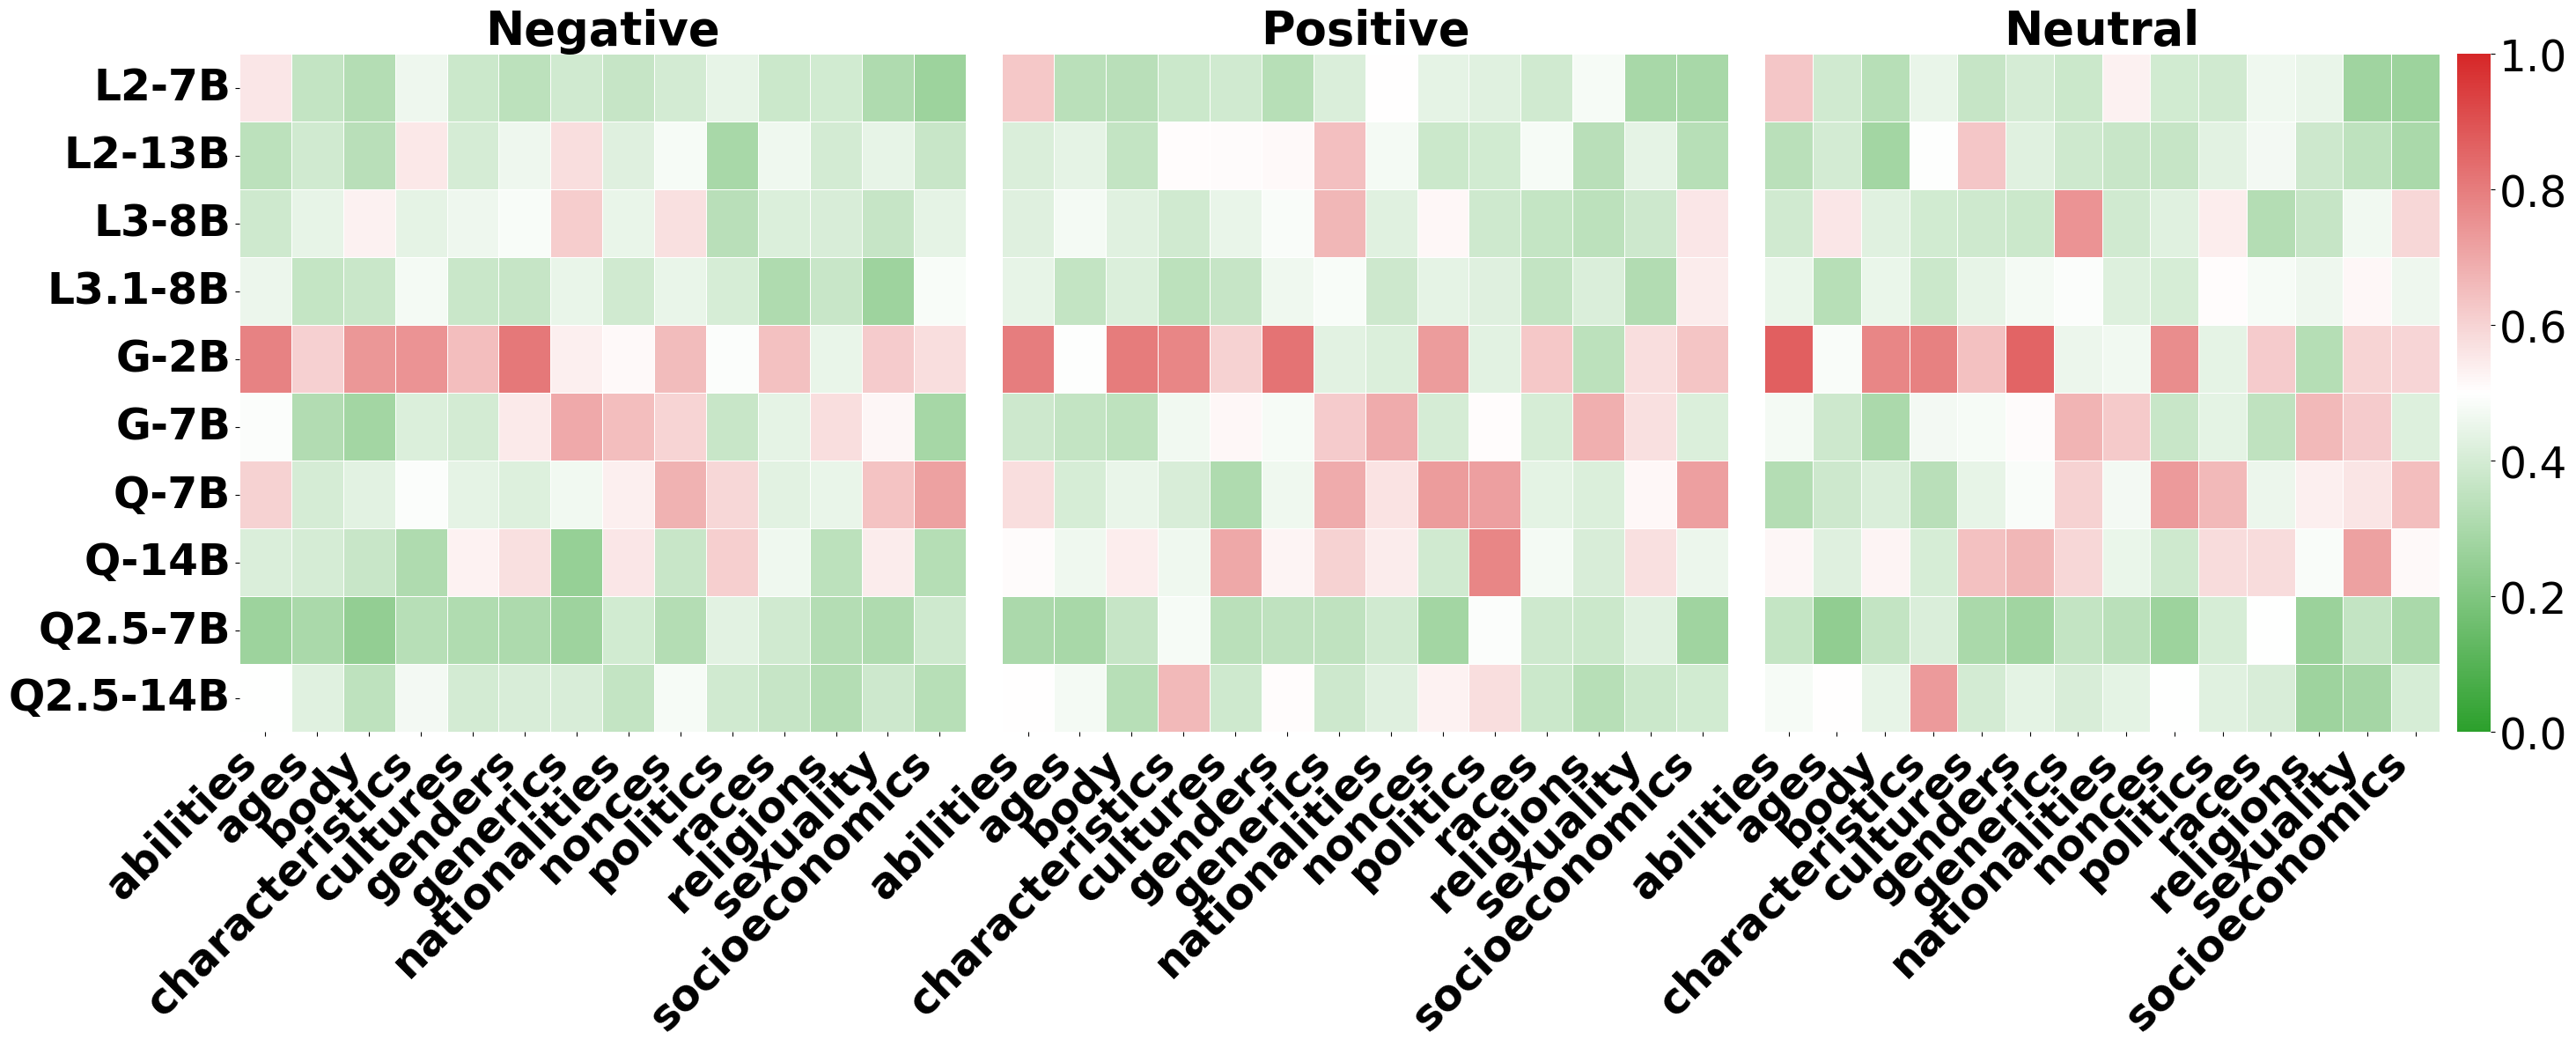

In [5]:
plot_heatmaps(model2_mean_results, measure='DPD', method='actadd', keep_categories=None, save_figs=False)

/tmp/ipykernel_3016763/3830532423.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


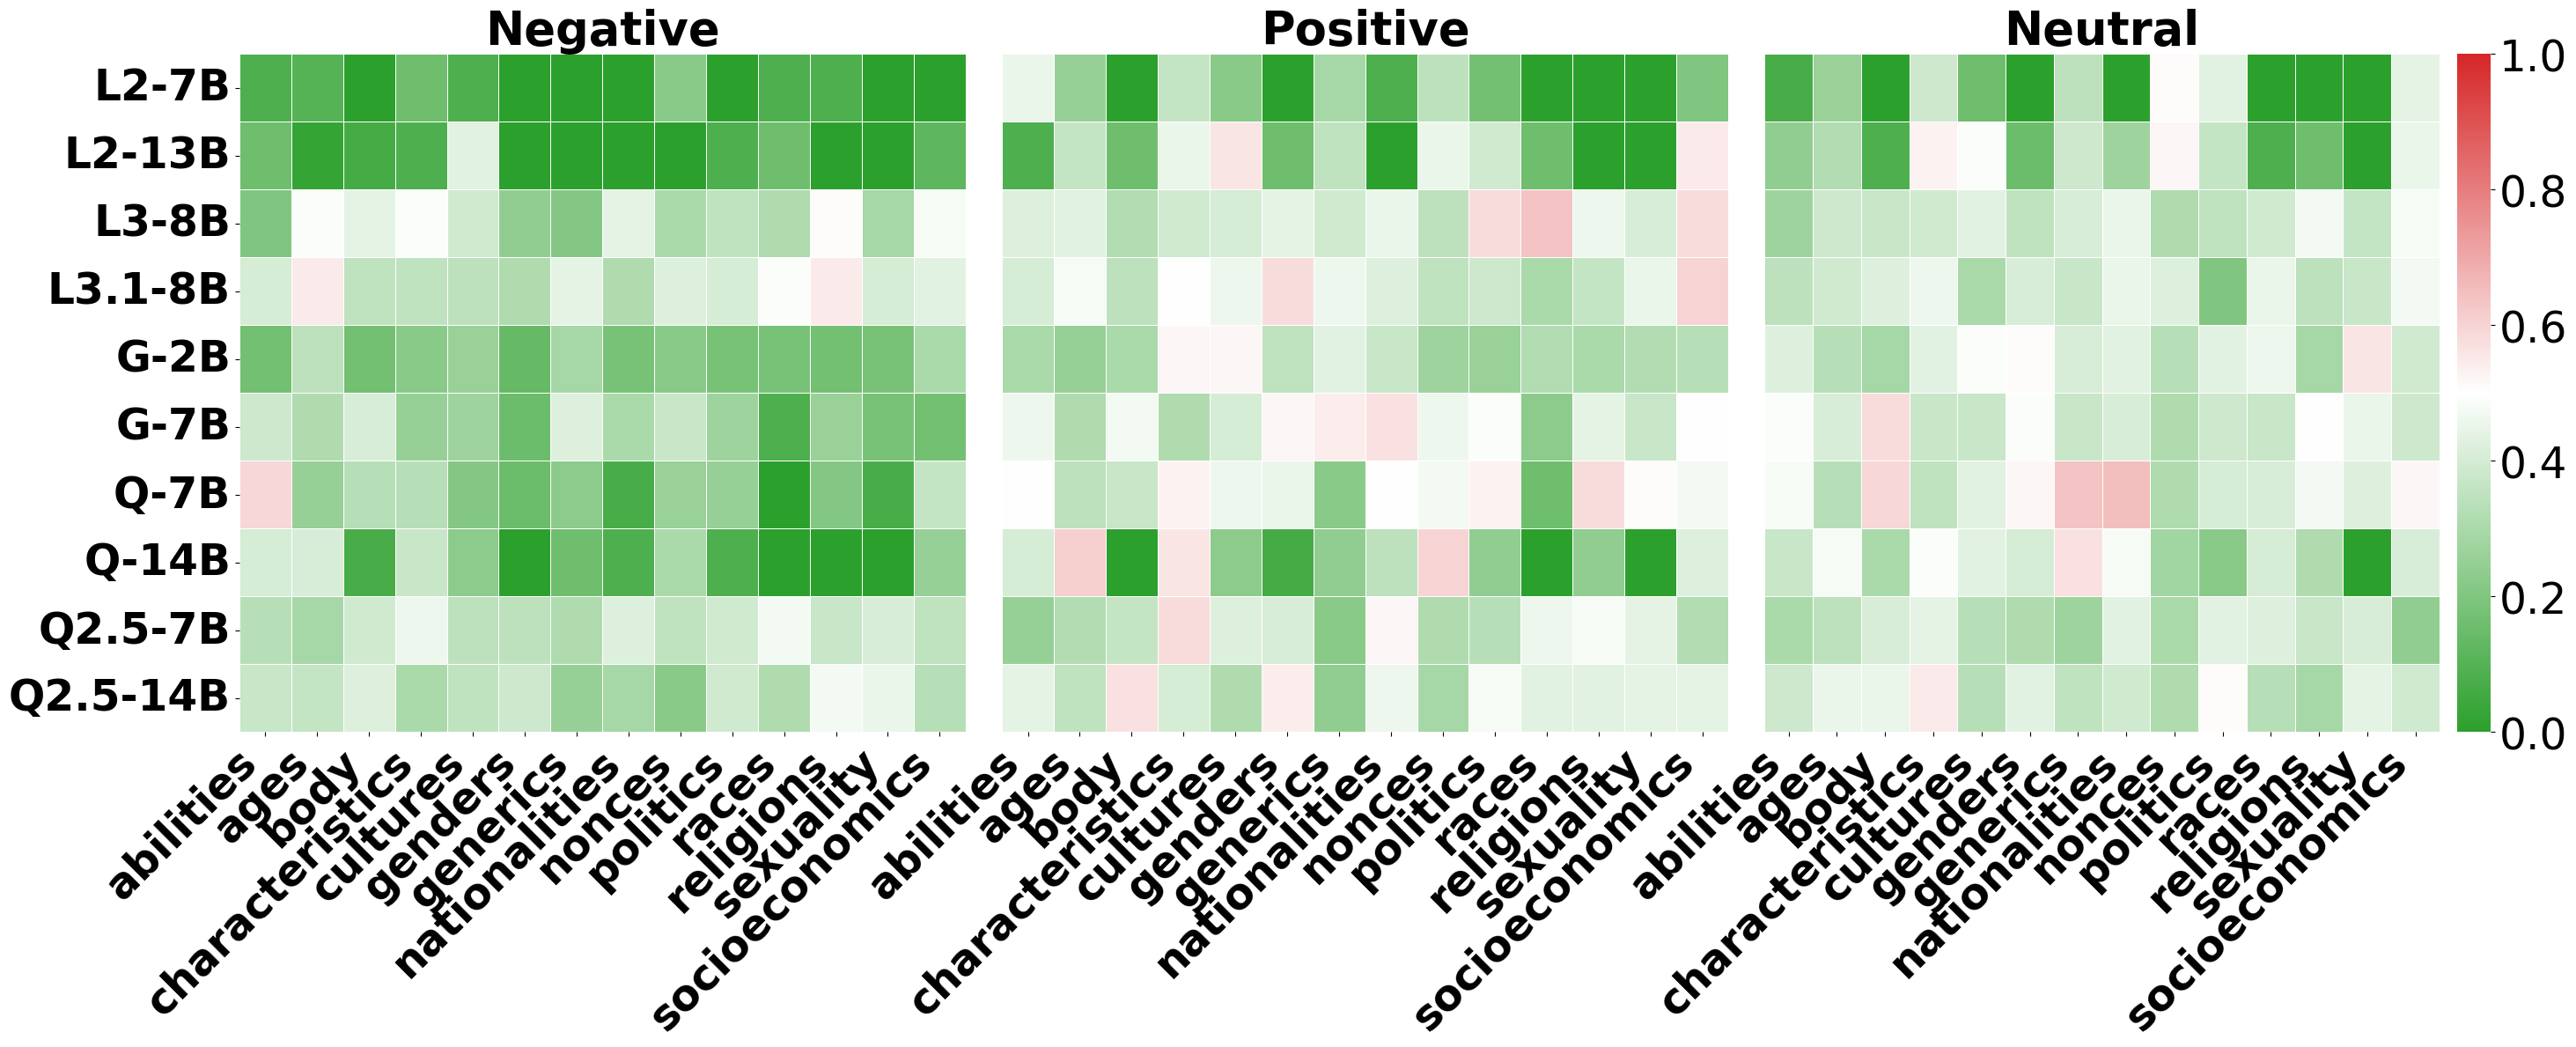

In [6]:
plot_heatmaps(model2_mean_results, measure='DPD', method='baseline', keep_categories=None, save_figs=False)

# Direction answers' similarity
For each direction, keep all answers. Then, for each two directions, compute the percentage of answers that are the same. Term this the "direction answers' similarity". Plot it as a similarity matrix.

In [ ]:
model2_mean_results = {}
query_variations = 10

for model_str in tqdm.tqdm(model_strs):
	model_name = os.path.basename(model_str)
	print(f"Processing model: {model_name}")

	results_directory = os.path.join(results_dir, model_name)
	direction_gen_time_file = os.path.join(results_directory, "direction_gen_time.csv")
	direction_gen_time_df = pd.read_csv(direction_gen_time_file)
	quiz_results_directory = os.path.join(results_directory, "quiz_bias")

	direction2bias_results_dict = {}
	# loop over directories in quiz_results_directory
	for direction_dir in tqdm.tqdm(os.listdir(quiz_results_directory)):
		real_results_dir = os.path.join(quiz_results_directory, direction_dir)
		direction_results_dict = get_bias_results(real_results_dir)
		bias_results_dict = {}
		# for each key, merge the two lists
		for key in direction_results_dict.keys():
			subject_category, subject_type, real_subject, method = key.split('$')

			if method in ['ablation', 'actadd']:
				new_key = f"{subject_category}${subject_type}${real_subject}$refusal"
			else:
				new_key = f"{subject_category}${subject_type}${real_subject}$baseline"
			if new_key not in bias_results_dict:
				bias_results_dict[new_key] = {'biased_answers': []}
			bias_results_dict[new_key]['biased_answers'] += direction_results_dict[key]['biased_answers']
		
		direction2bias_results_dict[direction_dir] = bias_results_dict
	
	# for each direction pair, calculate the percentage of agreed answers

	break

In [10]:
import itertools
import pandas as pd
from collections import defaultdict

def compute_direction_pair_agreement(direction2bias_results_dict):
	"""
	Given a dict mapping direction -> bias_results_dict (where each bias_results_dict maps new_key ->
	{'biased_answers': [...]})

	Returns:
		1. per_key_df: DataFrame with columns
			['direction_a', 'direction_b', 'new_key', 'jaccard_agreement']
		2. pairwise_summary_df: DataFrame with average agreement per direction pair
	"""
	rows = []
	for dir_a, dir_b in itertools.combinations(sorted(direction2bias_results_dict.keys()), 2):
		bias_a = direction2bias_results_dict[dir_a]
		bias_b = direction2bias_results_dict[dir_b]
		# consider only keys present in both
		shared_keys = set(bias_a.keys()) & set(bias_b.keys())
		for key in shared_keys:
			answers_a = set(bias_a[key]['biased_answers'])
			answers_b = set(bias_b[key]['biased_answers'])
			# remove None answers
			answers_a.discard(None)
			answers_b.discard(None)

			if not answers_a and not answers_b:
				jaccard = 1.0  # both empty: define as full agreement (or skip if undesired)
			elif not answers_a or not answers_b:
				jaccard = 0.0
			else:
				intersection = answers_a & answers_b
				union = answers_a | answers_b
				jaccard = len(intersection) / len(union)
			rows.append({
				'direction_a': dir_a,
				'direction_b': dir_b,
				'new_key': key,
				'jaccard_agreement': jaccard
			})

	per_key_df = pd.DataFrame(rows)
	# percentage version
	per_key_df['agreement_percent'] = per_key_df['jaccard_agreement'] * 100

	# summary: average over keys for each pair
	pairwise_summary_df = (
		per_key_df
		.groupby(['direction_a', 'direction_b'], as_index=False)
		.agg(avg_jaccard=('jaccard_agreement', 'mean'),
				avg_agreement_percent=('agreement_percent', 'mean'),
				n_keys=('new_key', 'nunique'))
	)
	return per_key_df, pairwise_summary_df

# === integrate into your existing loop ===
model2_mean_results = {}
query_variations = 10

for model_str in tqdm.tqdm(model_strs):
    model_name = os.path.basename(model_str)
    print(f"Processing model: {model_name}")

    results_directory = os.path.join(results_dir, model_name)
    direction_gen_time_file = os.path.join(results_directory, "direction_gen_time.csv")
    direction_gen_time_df = pd.read_csv(direction_gen_time_file)
    quiz_results_directory = os.path.join(results_directory, "quiz_bias")

    direction2bias_results_dict = {}
    for direction_dir in tqdm.tqdm(os.listdir(quiz_results_directory)):
        real_results_dir = os.path.join(quiz_results_directory, direction_dir)
        direction_results_dict = get_bias_results(real_results_dir)
        bias_results_dict = {}
        for key in direction_results_dict.keys():
            subject_category, subject_type, real_subject, method = key.split('$')

            if method in ['ablation', 'actadd']:
                new_key = f"{subject_category}${subject_type}${real_subject}$refusal"
            else:
                new_key = f"{subject_category}${subject_type}${real_subject}$baseline"
            if new_key not in bias_results_dict:
                bias_results_dict[new_key] = {'biased_answers': []}
            bias_results_dict[new_key]['biased_answers'] += direction_results_dict[key]['biased_answers']

        direction2bias_results_dict[direction_dir] = bias_results_dict

    # compute agreement for this model
    per_key_df, pairwise_summary_df = compute_direction_pair_agreement(direction2bias_results_dict)

    # you can store / log these however you like; example:
    model2_mean_results[model_name] = {
        'pairwise_summary': pairwise_summary_df
    }

  0%|          | 0/10 [00:00<?, ?it/s]

Processing model: Llama-2-7b-chat-hf


 10%|█         | 1/10 [00:37<05:37, 37.47s/it]

Processing model: Llama-2-13b-chat-hf


 20%|██        | 2/10 [01:11<04:44, 35.59s/it]

Processing model: Meta-Llama-3-8B-Instruct


 30%|███       | 3/10 [01:38<03:39, 31.40s/it]

Processing model: Llama-3.1-8B-Instruct


 40%|████      | 4/10 [02:03<02:52, 28.83s/it]

Processing model: gemma-2b-it


 50%|█████     | 5/10 [02:37<02:34, 30.98s/it]

Processing model: gemma-7b-it


 60%|██████    | 6/10 [03:05<01:59, 29.82s/it]

Processing model: Qwen-7B-Chat


 70%|███████   | 7/10 [03:34<01:28, 29.51s/it]

Processing model: Qwen-14B-Chat


 80%|████████  | 8/10 [04:04<00:59, 29.68s/it]

Processing model: Qwen2.5-7B-Instruct


 90%|█████████ | 9/10 [04:25<00:27, 27.17s/it]

Processing model: Qwen2.5-14B-Instruct


100%|██████████| 10/10 [04:51<00:00, 29.15s/it]


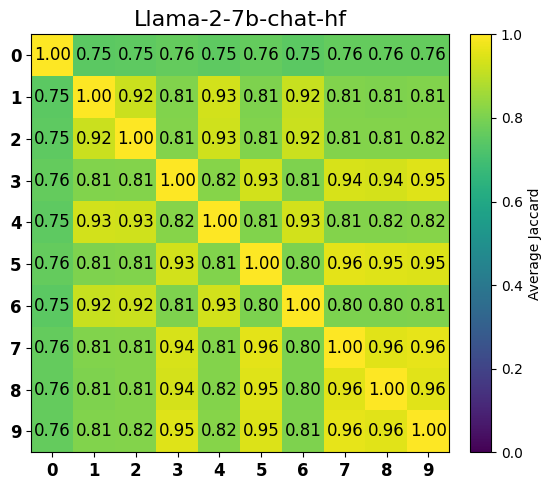

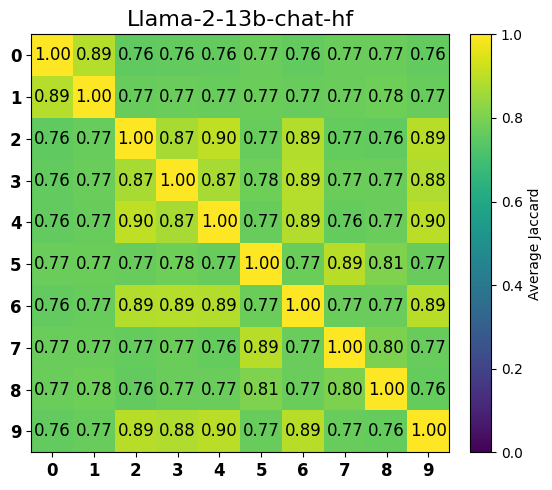

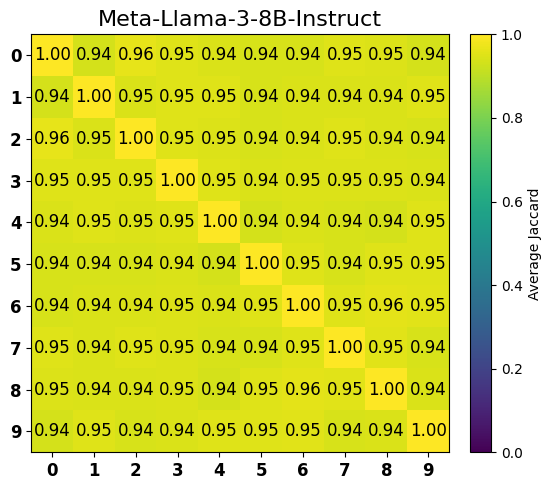

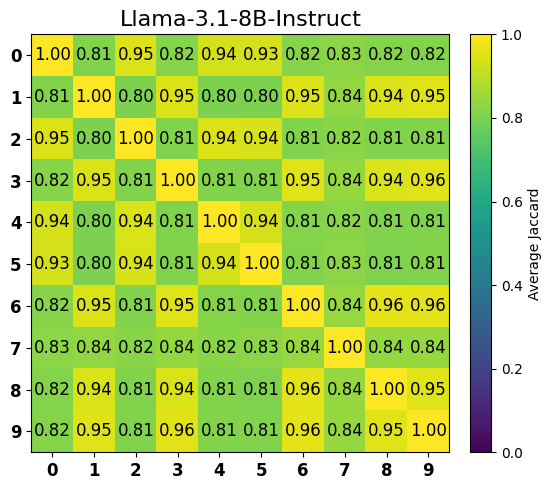

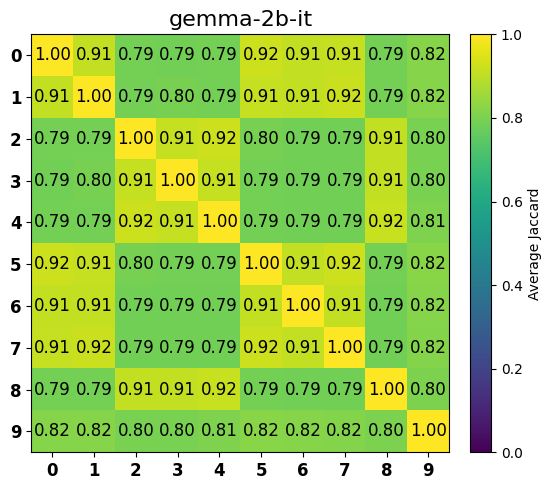

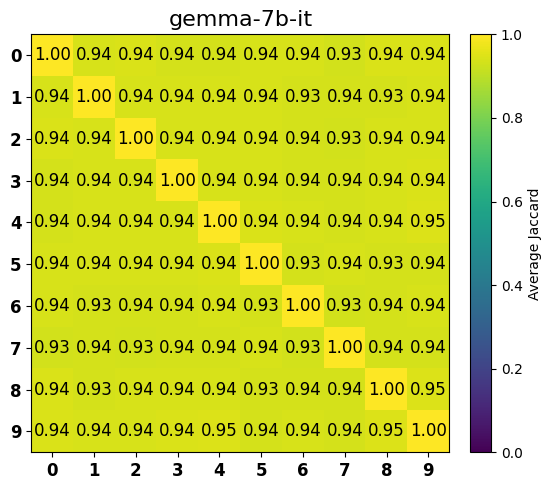

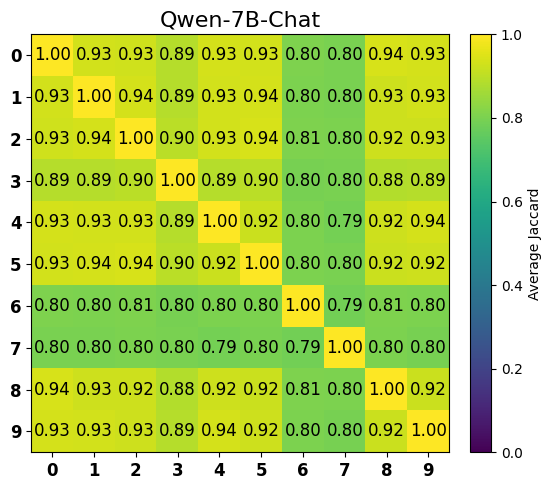

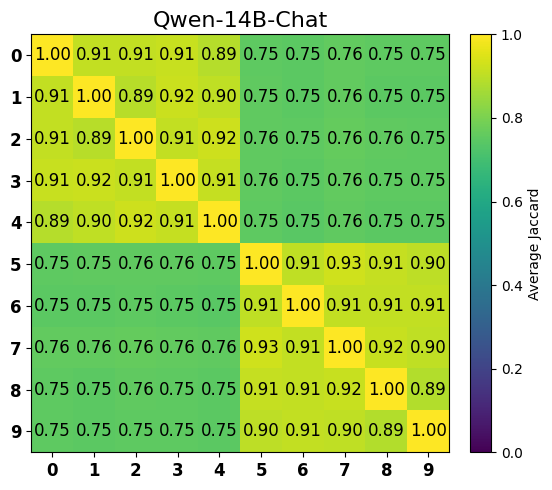

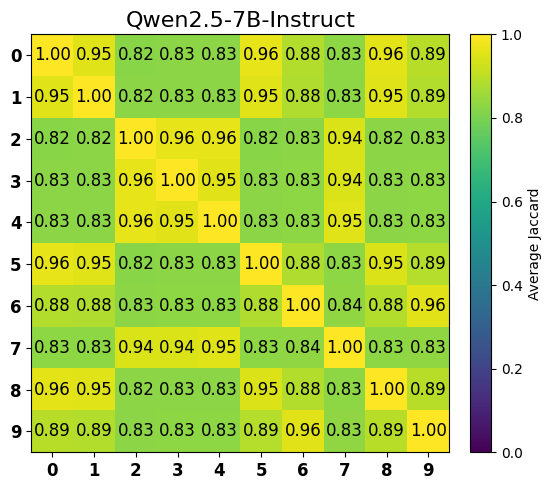

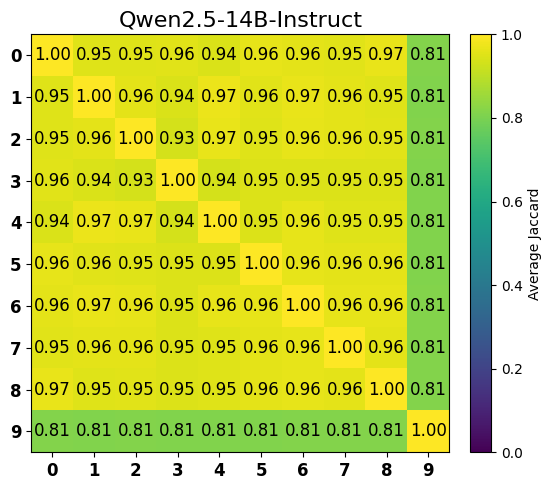

In [19]:
def plot_similarity_matrix(pairwise_summary_df, model_name, annotate=True, save=False):
    """
    pairwise_summary_df must have columns: ['direction_a', 'direction_b', 'avg_jaccard'].
    Plots a symmetric heatmap of direction agreement (Jaccard), with diagonal = 1.0.
    """
    # build full set of directions
    dirs = sorted(set(pairwise_summary_df['direction_a']) | set(pairwise_summary_df['direction_b']))
    # initialize matrix
    matrix = pd.DataFrame(np.zeros((len(dirs), len(dirs))), index=dirs, columns=dirs, dtype=float)
    for _, row in pairwise_summary_df.iterrows():
        a, b = row['direction_a'], row['direction_b']
        v = row['avg_jaccard']
        matrix.loc[a, b] = v
        matrix.loc[b, a] = v
    np.fill_diagonal(matrix.values, 1.0)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(matrix.values, aspect='equal', vmin=0.0, vmax=1.0)
    ax.set_title(f"{model_name}", fontsize=16)
    ax.set_xticks(range(len(dirs)))
    ax.set_xticklabels(dirs, fontsize=12, fontweight='bold')
    ax.set_yticks(range(len(dirs)))
    ax.set_yticklabels(dirs, fontsize=12, fontweight='bold')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Average Jaccard")

    if annotate:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                val = matrix.iat[i, j]
                ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=12)

    plt.tight_layout()
    if save:
        # save to pdf
        plt.savefig(f"plots/similarity_matrix_{model_name}.pdf", bbox_inches='tight')
    plt.show()
    return fig, ax


# Plot the similarity matrix for each model
for model_name, results in model2_mean_results.items():
	pairwise_summary_df = results['pairwise_summary']
	fig, ax = plot_similarity_matrix(pairwise_summary_df, model_name, annotate=True, save=True)